# TASK #1: UNDERSTAND THE PROBLEM STATMENT AND BUSINESS CASE


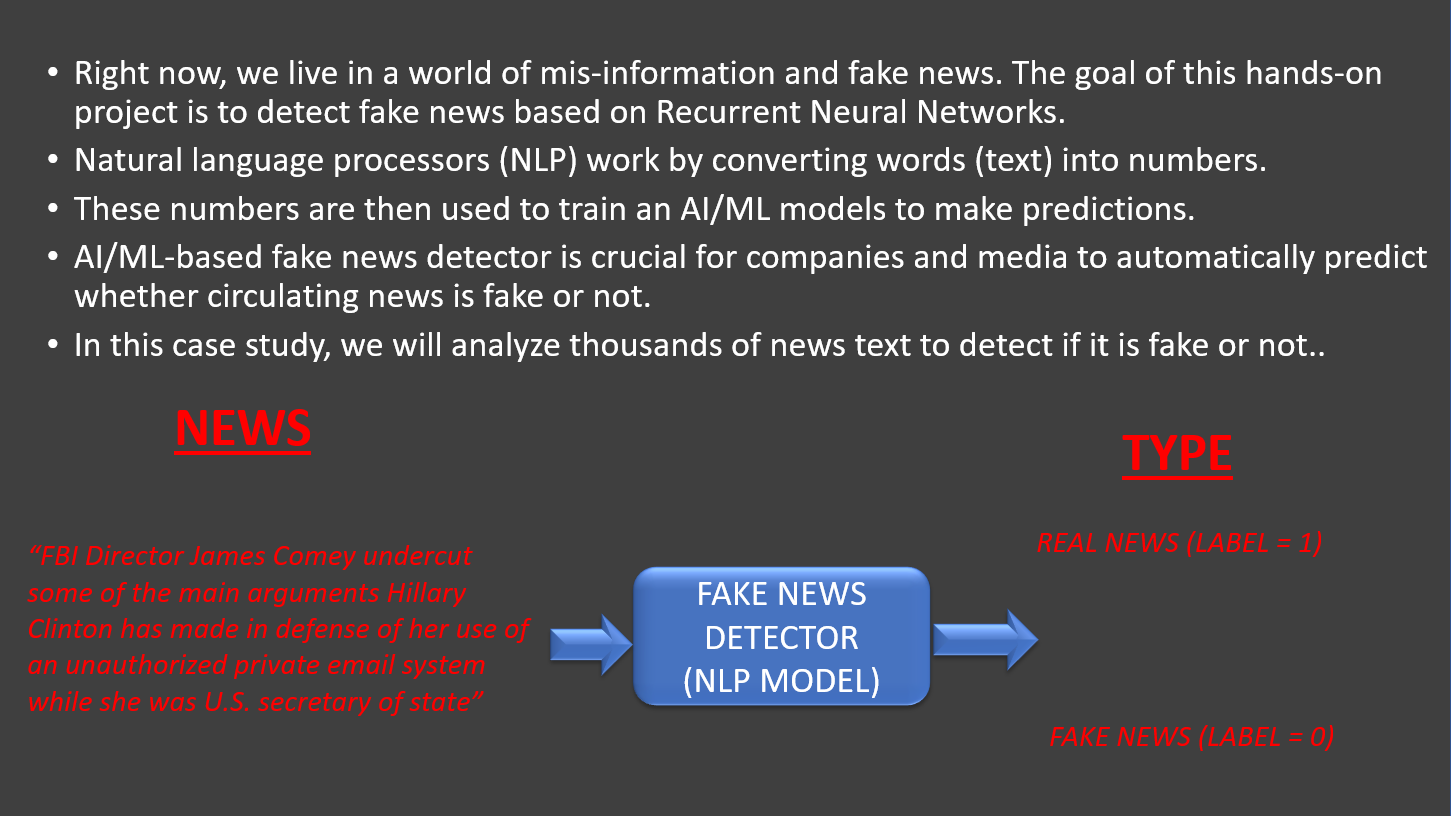


# Imports


In [1]:
import nltk

nltk.download("punkt")
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /Users/benchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Setup Configs


In [2]:
@dataclass
class CONFIG:
    TRUE_CSV: str = "True.csv"
    FAKE_CSV: str = "Fake.csv"
    DEVICE: str = "mps" if torch.backends.mps.is_built() else "cpu"

    BATCH_SIZE: int = 32
    EPOCHS: int = 25
    LR: float = 3e-3

# Examine the dataset


In [ ]:
# load the data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")

In [ ]:
df_true.head()

In [ ]:
df_true.isnull().sum()

In [ ]:
df_fake.isnull().sum()

MINI CHALLENGE #1:

- Indicate how many data samples do we have per class (i.e.: Fake and True)
- List how many Null element are present and the memory usage for each dataframe


# Preparing the dataset


In [ ]:
# add a target class column to indicate whether the news is real or fake
df_true = df_true.assign(isfake=1)
df_true.head()

In [ ]:
df_fake = df_fake.assign(isfake=0)
df_fake.head()

In [ ]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)
df

In [ ]:
df.drop(columns=["date"], inplace=True)

In [ ]:
# combine title and text together
df = df.assign(original=(df["title"] + " " + df["text"]))
df.head()

In [ ]:
df["original"][0]

# TASK #4: PERFORM DATA CLEANING


In [ ]:
# download stopwords
nltk.download("stopwords")

In [ ]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use"])

In [ ]:
stop_words

In [ ]:
def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Initialize the result list
    result = []

    # Process each token
    for token in tokens:
        # Convert to lower case
        token = token.lower()

        # Check if the token is a stop word or if its length is less than or equal to 3
        if token not in stop_words and len(token) > 3:
            result.append(token)

    return result

In [ ]:
# Apply the function to the dataframe
df["clean"] = df["original"].apply(preprocess)

In [ ]:
# Show original news
df["original"][0]

In [ ]:
# Show cleaned up news after removing stopwords
print(df["clean"][0])

In [ ]:
df

In [ ]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [ ]:
list_of_words

In [ ]:
len(list_of_words)

In [ ]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

In [ ]:
# join the words into a string
df["clean_joined"] = df["clean"].apply(lambda x: " ".join(x))

In [ ]:
df

In [ ]:
df["clean_joined"][0]

MINI CHALLENGE #2:

- Perform sanity check on the prepocessing stage by visualizing at least 3 sample news


# TASK #5: VISUALIZE CLEANED UP DATASET


In [ ]:
df

In [ ]:
# plot the number of samples in 'subject'
plt.figure(figsize=(8, 8))
sns.countplot(y="subject", data=df, hue="subject")

MINI CHALLENGE #3:

- Plot the count plot for fake vs. true news


In [ ]:
plt.figure(figsize=(8, 8))
sns.countplot(y="isfake", data=df, hue="isfake")

In [ ]:
# plot the word cloud for text that is Real
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(
    " ".join(df[df.isfake == 1].clean_joined)
)
plt.imshow(wc, interpolation="bilinear")

In [ ]:
# plot the word cloud for text that is Fake
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(
    " ".join(df[df.isfake == 0].clean_joined)
)
plt.imshow(wc, interpolation="bilinear")

In [ ]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if maxlen < len(tokens):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

In [ ]:
# visualize the distribution of number of words in a text
import plotly.express as px

fig = px.histogram(x=[len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins=100)
fig.show()

In [ ]:
from nltk import word_tokenize

# Create custom dataset


In [3]:
@dataclass
class CONFIG:
    TRUE_CSV: str = "True.csv"
    FAKE_CSV: str = "Fake.csv"
    DEVICE: str = "mps" if torch.backends.mps.is_built() else "cpu"

    BATCH_SIZE: int = 32
    EPOCHS: int = 25
    LR: float = 3e-3


config = CONFIG()

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import tiktoken
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")


class NewsDataset(Dataset):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.df = self.process_dataframe()
        self.maxlen = self.get_maxlen()
        self.total_words = self.total_words_in_corpus()

        # Initialize tokenizer and padding token ID
        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.pad_token_id = 50256
        self.encoded_padded = self.encode_and_pad_texts()

    def process_dataframe(self) -> pd.DataFrame:
        # read
        df_true = pd.read_csv(self.config.TRUE_CSV)
        df_fake = pd.read_csv(self.config.FAKE_CSV)

        # assign labels
        df_true = df_true.assign(isfake=1)
        df_fake = df_fake.assign(isfake=0)

        # concat real and fake
        df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)

        # drop column "date"
        df = df.drop(columns=["date"], inplace=False)

        # combine title and text context together
        df = df.assign(original=(df["title"] + " " + df["text"]))

        # apply the stop_words_preprocess func
        df = df.assign(clean=df["original"].apply(self.stop_words_preprocess))

        # join the words into a string
        df = df.assign(clean_joined=(df["clean"].apply(lambda x: " ".join(x))))

        return df

    def get_maxlen(self) -> int:
        maxlen = -1
        for doc in self.df["clean_joined"]:
            tokens = nltk.word_tokenize(doc)
            if maxlen < len(tokens):
                maxlen = len(tokens)
        return maxlen

    def stop_words_preprocess(self, text) -> list:
        stop_words = set(stopwords.words("english"))

        # tokenize the text
        tokens = word_tokenize(text.lower())
        result = [
            token for token in tokens if token not in stop_words and len(token) > 1
        ]
        return result

    def total_words_in_corpus(self) -> int:
        # list_of_words = []
        # for clean_news in df["clean"]:
        #     for word in clean_news:
        #         list_of_words.append(word)

        # total_words = len(list(set(list_of_words)))
        all_words = [word for text in self.df["clean"] for word in text]
        return len(set(all_words))

    def __len__(self):
        return len(self.df)

    def encode_and_pad_texts(self) -> list:
        # encode texts and pad them to maxlen
        encoded_texts = [
            self.tokenizer.encode(text) for text in self.df["clean_joined"]
        ]
        return [
            encoded_text + [self.pad_token_id] * (self.maxlen - len(encoded_text))
            for encoded_text in encoded_texts
        ]

    def __getitem__(self, idx):

        encoded = self.encoded_padded[idx]
        label = self.df["isfake"].iloc[idx]

        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long),
        )

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/benchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
dataset = NewsDataset(config)

In [ ]:
len(dataset)

encoded, label = dataset[0]

In [ ]:
len(dataset)

# Split to train, val, test dataset


In [6]:
from torch.utils.data import random_split

train_full, test_ds = random_split(dataset, lengths=[0.9, 0.1])
train_ds, val_ds = random_split(train_full, lengths=[0.9, 0.1])

len(train_ds), len(val_ds), len(test_ds)

: 

In [ ]:
sample_seq, sample_target = train_ds[0]
sample_seq, sample_target

sample_seq.shape

# Create DataLoaders


In [ ]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(
    dataset=train_ds, batch_size=config.BATCH_SIZE, shuffle=True
)
val_dataloader = DataLoader(dataset=val_ds, batch_size=config.BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(
    dataset=test_ds, batch_size=config.BATCH_SIZE, shuffle=False
)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

In [ ]:
sample_batch_seq, sample_batch_label = next(iter(train_dataloader))
# sample_batch_seq.shape, sample_batch_label.shape

print(
    f"sample_batch_seq.shape: {sample_batch_seq.shape}"
    f"\nsample_batch_label.shape: {sample_batch_label.shape}"
)

In [ ]:
dataset.total_words

# Create the model


In [ ]:
class BiLSTMModel(nn.Module):

    def __init__(
        self,
        total_words,
        num_layers,
        embedding_dim=128,
        hidden_dim=128,
        num_classes=2,
        device=config.DEVICE,
    ):
        super().__init__()
        self.device = device
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(
            num_embeddings=total_words, embedding_dim=embedding_dim
        )
        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.fc1 = nn.Linear(in_features=hidden_dim * 2, out_features=hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(
            self.device
        )
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(
            self.device
        )

        x = self.embedding(x)  # after this: shape = ([1, 4942, 128])
        x, (hidden_state, cell_state) = self.bilstm(x, (h0, c0))
        x = x[:, -1, :]  # take the output of the last time step
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = BiLSTMModel(total_words=dataset.total_words, num_layers=2).to(config.DEVICE)
model

In [ ]:
sample_data = train_ds[0]
sample_features = sample_data[0]
sample_features = sample_features.to(config.DEVICE)

print(sample_features.shape)  # torch.Size([4942])
sample_features = sample_features.unsqueeze(dim=0)
print(sample_features.shape)  # torch.Size([1, 4942])
output = model(sample_features)

print("\nsample output:")
output

In [ ]:
total_words = 100
embedding_dim = 128
num_layers = 2
hidden_dim = 256
num_classes = 2
batch_size = 32

# num_layers*2, batch, hideen_dim
h0 = torch.zeros(num_layers * 2, batch_size, hidden_dim)

# num_layers*2, batch, hideen_dim
c0 = torch.zeros(num_layers * 2, batch_size, hidden_dim)

# batch, seq_len
sample = torch.zeros(size=(batch_size, 4942), dtype=torch.long)

embedding = nn.Embedding(num_embeddings=total_words, embedding_dim=embedding_dim)
bilstm = nn.LSTM(
    input_size=embedding_dim,  # 128
    hidden_size=hidden_dim,  # 256
    bidirectional=True,
    batch_first=True,
    num_layers=num_layers,
)
fc1 = nn.Linear(in_features=hidden_dim * 2, out_features=hidden_dim)
fc2 = nn.Linear(hidden_dim, num_classes)
relu = nn.ReLU()

print(f"input.shape: {sample.shape}")
output = embedding(sample)
print(f"shape after embedding: {output.shape}")
output, (hidden_state, cell_state) = bilstm(output, (h0, c0))
print(f"shape after bilstm: {output.shape}")
output = output[:, -1, :]
print(f"shape after above: {output.shape}")
output = fc1(output)
print(f"shape after fc1: {output.shape}")
output = relu(output)
print(f"shape after relu: {output.shape}")
output = fc2(output)
print(f"shape after fc2: {output.shape}")

# Sample flow


In [ ]:
model = BiLSTMModel(total_words=dataset.total_words, num_layers=2).to(config.DEVICE)

sample_batch_seq, sample_batch_target = next(iter(train_dataloader))

print(
    f"sample_batch_seq.shape: {sample_batch_seq.shape}"
    f"\nsample_batch_target.shape: {sample_batch_target.shape}"
)

sample_batch_seq = sample_batch_seq.to(config.DEVICE)
sample_batch_target = sample_batch_target.to(config.DEVICE)

loss_fn = nn.CrossEntropyLoss()

logits = model(sample_batch_seq)
preds = torch.argmax(logits, dim=-1)

accuracy = (preds == sample_batch_target).sum().cpu().numpy() / len(sample_batch_target)
loss = loss_fn(logits, sample_batch_target)
loss

# accuracy

In [ ]:
(preds == sample_batch_target).sum().cpu() / 32

In [ ]:
# # Sequential Model
# model = Sequential()

# # embeddidng layer
# model.add(Embedding(total_words, output_dim=128))
# # model.add(Embedding(total_words, output_dim = 240))


# # Bi-Directional RNN and LSTM
# model.add(Bidirectional(LSTM(128)))

# # Dense layers
# model.add(Dense(128, activation="relu"))
# model.add(Dense(1, activation="sigmoid"))
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model.summary()

# Create Train and Validation funcs


In [ ]:
from tqdm import tqdm


def train_fn(model, dataloader, optimizer, device=config.DEVICE):

    model.train()

    total_loss = 0
    total_acc = 0

    loss_fn = nn.CrossEntropyLoss()
    for batch_seq, batch_label in tqdm(dataloader):
        batch_seq, batch_label = batch_seq.to(device), batch_label.to(device)

        logits = model(batch_seq)
        preds = torch.argmax(logits, dim=-1)
        loss = loss_fn(logits, batch_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_acc += (preds == batch_label).sum().cpu().numpy() / len(batch_label)
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    return avg_loss, avg_acc


def eval_fn(model, dataloader, device=config.DEVICE):

    model.eval()

    total_loss = 0
    total_acc = 0

    loss_fn = nn.CrossEntropyLoss()

    with torch.inference_mode():
        for batch_seq, batch_label in tqdm(dataloader):
            batch_seq, batch_label = batch_seq.to(device), batch_label.to(device)

            logits = model(batch_seq)
            preds = torch.argmax(logits, dim=-1)
            loss = loss_fn(logits, batch_label)

            total_acc += (preds == batch_label).sum().cpu().numpy() / len(batch_label)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    return avg_loss, avg_acc


def predict_fn(model, dataloader, device=config.DEVICE):

    model.eval()

    total_loss = 0
    total_acc = 0

    predictions_list = []
    targets_list = []

    loss_fn = nn.CrossEntropyLoss()

    with torch.inference_mode():
        for batch_seq, batch_label in tqdm(dataloader):
            batch_seq, batch_label = batch_seq.to(device), batch_label.to(device)

            logits = model(batch_seq)
            preds = torch.argmax(logits, dim=-1)
            loss = loss_fn(logits, batch_label)

            total_acc += (preds == batch_label).sum().cpu().numpy() / len(batch_label)
            total_loss += loss.item()

            predictions_list.append(preds.cpu().numpy())
            targets_list.append(batch_label.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    predictions_list = np.concatenate(predictions_list)
    targets_list = np.concatenate(targets_list)

    return avg_loss, avg_acc, predictions_list, targets_list

# Train the model


In [ ]:
model = BiLSTMModel(total_words=dataset.total_words, num_layers=2)
model.to(config.DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(), lr=config.LR)

best_val_loss = np.Inf

train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(config.EPOCHS):
    train_loss, train_acc = train_fn(model, train_dataloader, optimizer)
    val_loss, val_acc = eval_fn(model, val_dataloader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_test_loss:
        torch.save(model.state_dict(), "best_fake_ig_detector.pth")
        print("___SAVED BEST WEIGHTS___")
        best_test_loss = val_loss

    print(
        f"Epoch: {epoch+1:03d}/{config.EPOCHS:03d} | Best Valid loss: {best_test_loss:.4f}\n"
        f"Train loss: {train_loss:.4f} | Valid loss: {val_loss:.4f}"
    )

# Plotting


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.set(
    xlabel="Epochs",
    ylabel="Loss",
    title="Training vs. Validation Loss",
    xticks=np.arange(0, len(train_losses)),
)
ax.grid(True)
ax.legend(title="Loss")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

ax.plot(train_accs, label="Training")
ax.plot(val_accs, label="Validation")
ax.set(
    xlabel="Epochs",
    ylabel="Loss",
    title="Training vs. Validation Loss",
    xticks=np.arange(0, len(train_accs)),
)
ax.grid(True)
ax.legend(title="Loss")

plt.tight_layout()
plt.show()

# Inference


In [ ]:
model = BiLSTMModel(total_words=dataset.total_words, num_layers=2)
model.load_state_dict(torch.load(""))
model.to(config.DEVICE)

# Classification report


In [ ]:
test_losss, test_accs, predictions, ground_truths = predict_fn(model, test_dataloader)

print(classification_report(ground_truths, predictions))

# Confusion Matrix


In [ ]:
plt.figure(figsize=(8, 8))
cm = confusion_matrix(ground_truths, predictions)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()